In [1]:
import numpy as np
import random
import torch
import importlib
import os

import sys
sys.path.append('./../')

from models.network import AutoEncoder, ImageAutoEncoder
from data.data import ImNetImageSamples
from utils.debugger import MyDebugger
from torch.multiprocessing import Pool, Process, set_start_method


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


## dataload
### create dataset
data_path = r'/path/to/datasets/shapenet/prepared_v1/h5files/02691156.hdf5'

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
samples = ImNetImageSamples(data_path=data_path, use_depth=True, image_preferred_color_space=3)

Preferred color space is 3 but loaded are 4. Preferred or minimum value 3 will be used as more prioritized option.


In [3]:
import h5py
data_dict = h5py.File(data_path, 'r')
data_dict['pixels'].shape

(4045, 24, 127, 127, 4)

In [9]:
data_dict['depths'].shape

(4045, 24, 127, 127, 1)

In [4]:
import matplotlib.pyplot as plt

img_f = data_dict['pixels'][0, 3]
depth = data_dict['depths'][0, 3]

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(121)
plt.imshow(img_f[:, :, :3])

ax = fig.add_subplot(122)
plt.imshow((depth / 255.0) ** 8, cmap='hot', interpolation='nearest')

NameError: name 'data_dict' is not defined

In [5]:
samples.data_pixels.shape, samples.data_depths.shape

((4045, 24, 3, 128, 128), (4045, 24, 1, 128, 128))

In [6]:
indx = 2_008

(image, latent_vector_gt), idx = samples[indx]
obj_name = samples.obj_paths[indx]
obj_name, latent_vector_gt, idx

('02691156/86b11ae736659136ca8607f540cc62ba', None, 2008)

In [7]:
image.transpose(1, 2, 0).shape

(128, 128, 4)

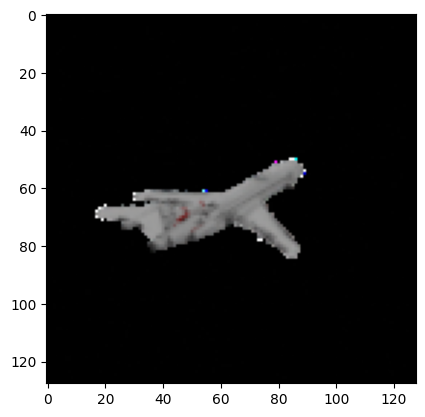

In [8]:
import matplotlib.pyplot as plt

image_rgb, depth = image[:samples.image_color_size].transpose(1, 2, 0), image[-1]

plt.imshow(image_rgb)

/tmp/ipykernel_2688295/1079351275.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(depth)


<AxesSubplot: ylabel='Density'>

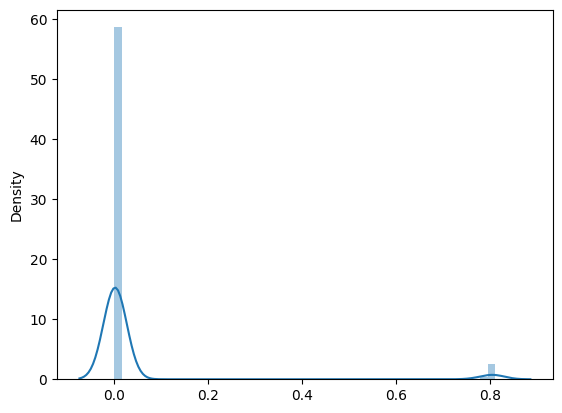

In [20]:
sns.distplot(depth)

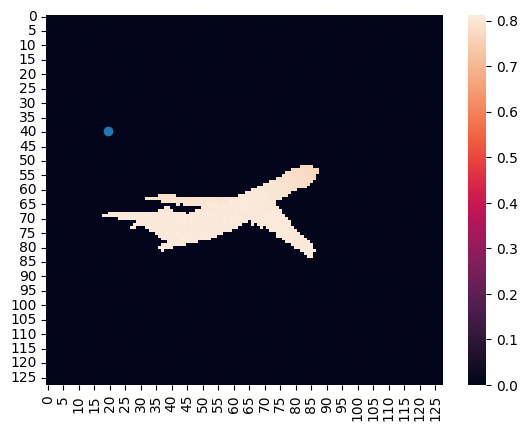

In [16]:
import seaborn as sns
sns.heatmap(depth)
plt.scatter([20], [40])

((128, 128), <matplotlib.image.AxesImage at 0x7f78acc06520>)

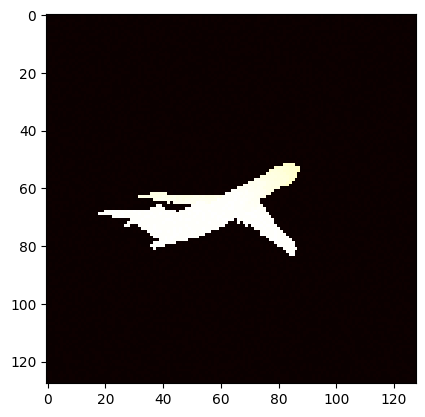

In [10]:
depth.shape, plt.imshow(depth, cmap='hot', interpolation='nearest')

((127, 127), <matplotlib.image.AxesImage at 0x7fb3e3c2e700>)

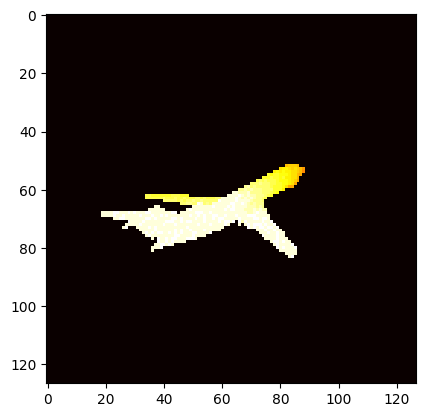

In [8]:
import cv2
depth_path = f'/path/to/datasets/shapenet/prepared_v1/render/{obj_name}/rendering/00_depth_0001.png'
depth_or = cv2.imread(depth_path)[:, :, 0]
depth_or.shape, plt.imshow((depth_or / 255.0) ** 8, cmap='hot', interpolation='nearest')

In [1]:
import h5py
import numpy as np

import matplotlib.pyplot as plt

data_dict_new = h5py.File('/path/to/datasets/shapenet/ShapeNetDepthCore.v2.h5/splitted/dataset_test.hdf5', 'r')
data_dict_new['pixels'].shape

(7957, 24, 137, 137, 3)

In [7]:
with open('/path/to/datasets/shapenet/ShapeNetDepthCore.v2.h5/splitted/dataset_test.txt', 'r') as fr:
    data_txt_new = list(map(lambda x: x.strip(), fr.readlines()))

In [29]:
data_dict = h5py.File('./../data/all_vox256_img/all_vox256_img_test.hdf5', 'r')
data_dict['pixels'].shape

(8762, 24, 137, 137)

In [30]:
with open('./../data/all_vox256_img/all_vox256_img_test.txt', 'r') as fr:
    data_txt = list(map(lambda x: x.strip(), fr.readlines()))

In [57]:
indx_new = 4022
find_obj = data_txt_new[indx_new]

indx = data_txt.index(find_obj)
indx_new, indx

(4022, 6788)

In [58]:
p_new = data_dict_new['points_64'][indx_new]
v_new = data_dict_new['values_64'][indx_new]
p = data_dict['points_64'][indx]
v = data_dict['values_64'][indx]

In [59]:
(p_new.shape, v_new.shape), (p.shape, v.shape)

(((16384, 3), (16384, 1)), ((16384, 3), (16384, 1)))

((2236, 3), (2308, 3))

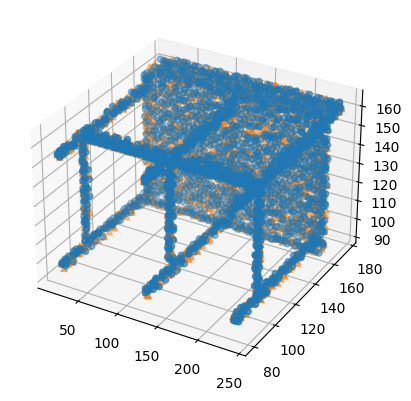

In [60]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

part_p_new = p_new[v_new[:, 0] > 1e-4]
part_p = p[v[:, 0] > 1e-4]
ax.scatter(part_p_new[:, 0], part_p_new[:, 1], part_p_new[:, 2], marker='o')
ax.scatter(part_p[:, 0], part_p[:, 1], part_p[:, 2], marker='^')

part_p_new.shape, part_p.shape

In [61]:
(part_p_new.mean(), part_p_new.std()), (part_p.mean(), part_p.std())

((134.7747465712582, 48.62667748242625),
 (134.8630849220104, 48.76772693815385))